# BME-Crete Master Thesis (Results analysis)
### by **Stylianos Zafeiris**

### Imports and necessary variable declarations

In [148]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt

Useful functions

In [149]:
def printMaxScore(scoreName, dataset):
    bestScore = dataset.loc[dataset[scoreName].idxmax()]
    print(f"{'='*11} Max {scoreName} {'='*11}\n{bestScore}\n")

#### Make sure that all results are extracted

In [126]:
! python .\extract_results.py

c:\Users\szafeiris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\szafeiris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\szafeiris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\szafeir

#### Declare datasets' results paths and load them

Read datasets and load them. Then merge them into one dataframe and sort it.

In [151]:
origDatasetPath = Path('./data/results/original_results.csv')
origDataset = pd.read_csv(origDatasetPath.absolute())

origNormDatasetPath = Path('./data/results/original_norm_results.csv')
origNormDataset = pd.read_csv(origNormDatasetPath.absolute())

n4DatasetPath = Path('./data/results/n4_results.csv')
n4Dataset = pd.read_csv(n4DatasetPath.absolute())

n4NormDatasetPath = Path('./data/results/n4_norm_results.csv')
n4NormDataset = pd.read_csv(n4NormDatasetPath.absolute())

fatDatasetPath = Path('./data/results/fat_results.csv')
fatDataset = pd.read_csv(fatDatasetPath.absolute())

muscleDatasetPath = Path('./data/results/muscle_results.csv')
muscleDataset = pd.read_csv(muscleDatasetPath.absolute())


merged = pd.concat([origDataset, origNormDataset, n4Dataset, n4NormDataset, fatDataset, muscleDataset], ignore_index=True)
merged.sort_values(by=['balanced_accuracy_score', 'roc_auc_score', 'datasetName', 'featureSelectionMethodName', 'classifierName'])

# Add extra columns
merged['fullDatasetName'] = merged.apply(lambda x: f"{x['datasetName']}{'_norm' if x['isNormalized'] else ''}", axis=1, )

merged['sensitivity'] = merged.apply(lambda x: x["TP"] / (x["TP"] + x["FN"]), axis=1)
merged['speficity'] = merged.apply(lambda x: x["TN"] / (x["TN"] + x["FP"]), axis=1)
merged

,featureSelectionMethodName,classifierName,datasetName,isNormalized,selectedFeaturesNo,selectedThreshold,accuracy_score,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,cohen_kappa_score,TN,FP,FN,TP,fullDatasetName,sensitivity,speficity
0,boruta,gnb,original,False,67,0.0,0.566667,0.558644,0.493506,0.475000,0.513514,0.558644,0.115869,32,21,18,19,original,0.513514,0.603774
1,boruta,knn,original,False,79,0.0,0.600000,0.533333,0.357143,0.384615,0.333333,0.533333,0.068966,44,16,20,10,original,0.333333,0.733333
2,boruta,rf,original,False,178,0.0,0.544444,0.528571,0.438356,0.421053,0.457143,0.528571,0.056266,33,22,19,16,original,0.457143,0.600000
3,boruta,svm-linear,original,False,130,0.0,0.533333,0.509259,0.400000,0.411765,0.388889,0.509259,0.018692,34,20,22,14,original,0.388889,0.629630
4,boruta,svm-rbf,original,False,61,0.0,0.644444,0.581408,0.407407,0.550000,0.323529,0.581408,0.177143,47,9,23,11,original,0.323529,0.839286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,surf,knn,muscle,False,78,0.0,0.633333,0.587963,0.440678,0.565217,0.361111,0.587963,0.187192,44,10,23,13,muscle,0.361111,0.814815
534,surf,rf,muscle,False,8,0.0,0.544444,0.513664,0.369231,0.444444,0.315789,0.513664,0.028436,37,15,26,12,muscle,0.315789,0.711538
535,surf,svm-linear,muscle,False,28,0.0,0.588889,0.516318,0.177778,0.500000,0.108108,0.516318,0.037016,49,4,33,4,muscle,0.108108,0.924528
536,surf,svm-rbf,muscle,False,3,0.0,0.644444,0.522143,0.200000,0.444444,0.129032,0.522143,0.053254,54,5,27,4,muscle,0.129032,0.915254


Count dataset sample size

In [152]:
merged.groupby(by='fullDatasetName')['fullDatasetName'].aggregate(['count'])

,count
fullDatasetName,
fat,90
muscle,90
n4,90
n4_norm,90
original,90
original_norm,88


### Main analysis

#### Create balanced accuracy boxplots

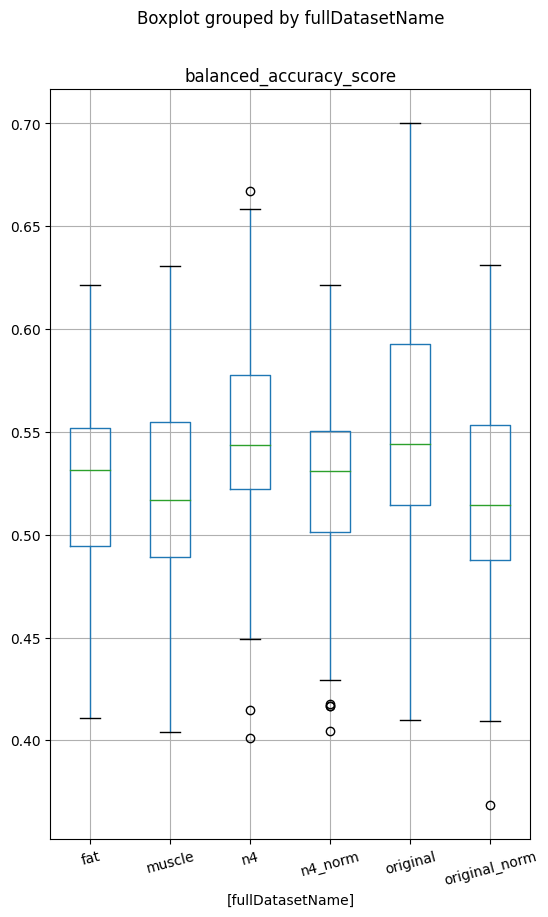

In [129]:
# Show boxplot for balanced acc
merged_bplt = merged.boxplot(
    column=[
        'balanced_accuracy_score',
    ],
    by= ['fullDatasetName'],
    rot=15, figsize=(6, 10) )
merged_bplt.plot()
plt.show()

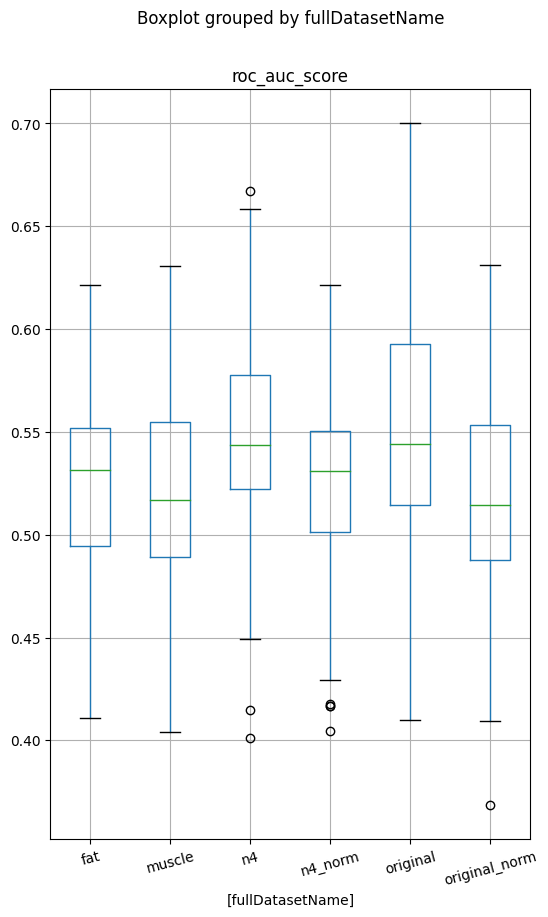

In [130]:
# Show boxplot for balanced acc
merged_bplt = merged.boxplot(
    column=[
        'roc_auc_score',
    ],
    by= ['fullDatasetName'],
    rot=15, figsize=(6, 10) )
merged_bplt.plot()
plt.show()

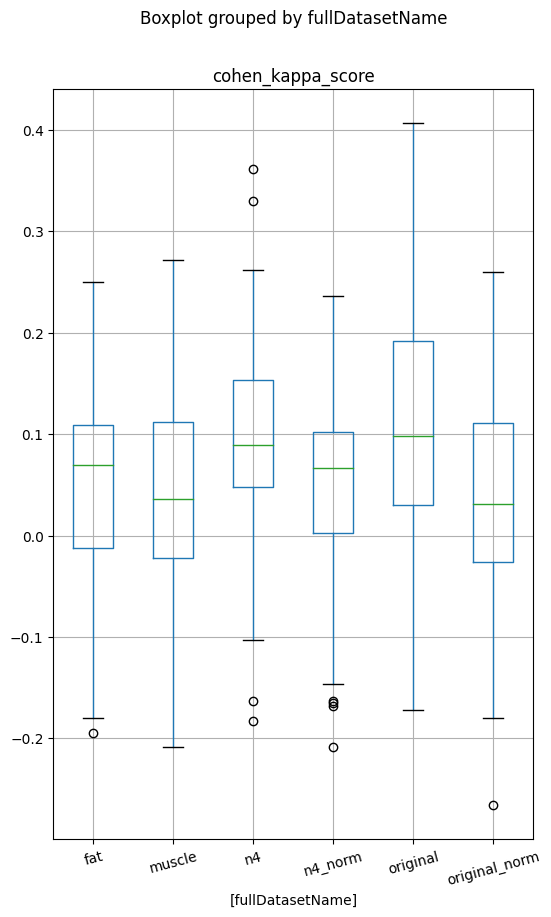

In [131]:
# Show boxplot for balanced acc
merged_bplt = merged.boxplot(
    column=[
        'cohen_kappa_score',
    ],
    by= ['fullDatasetName'],
    rot=15, figsize=(6, 10), )
merged_bplt.plot()
plt.show()

Print max scores

In [132]:
printMaxScore('balanced_accuracy_score', origDataset)


=========== Max balanced_accuracy_score ===========
featureSelectionMethodName     pearson
classifierName                     xgb
datasetName                   original
isNormalized                     False
selectedFeaturesNo                 175
selectedThreshold                 0.85
accuracy_score                0.722222
balanced_accuracy_score            0.7
f1_score                      0.626866
precision_score                0.65625
recall_score                       0.6
roc_auc_score                      0.7
cohen_kappa_score             0.406332
TN                                  44
FP                                  11
FN                                  14
TP                                  21
Name: 59, dtype: object



In [133]:
printMaxScore('balanced_accuracy_score', origNormDataset)

=========== Max balanced_accuracy_score ===========
featureSelectionMethodName       pearson
classifierName                svm-linear
datasetName                     original
isNormalized                        True
selectedFeaturesNo                   143
selectedThreshold                    0.7
accuracy_score                  0.644444
balanced_accuracy_score         0.631169
f1_score                        0.555556
precision_score                 0.540541
recall_score                    0.571429
roc_auc_score                   0.631169
cohen_kappa_score                0.25964
TN                                    38
FP                                    17
FN                                    15
TP                                    20
Name: 55, dtype: object



In [134]:
printMaxScore('balanced_accuracy_score', n4Dataset)

=========== Max balanced_accuracy_score ===========
featureSelectionMethodName     relieff
classifierName                     knn
datasetName                         n4
isNormalized                     False
selectedFeaturesNo                  68
selectedThreshold                  0.0
accuracy_score                0.722222
balanced_accuracy_score       0.667017
f1_score                      0.545455
precision_score               0.714286
recall_score                  0.441176
roc_auc_score                 0.667017
cohen_kappa_score             0.361158
TN                                  50
FP                                   6
FN                                  19
TP                                  15
Name: 61, dtype: object



In [135]:
printMaxScore('balanced_accuracy_score', n4NormDataset)

=========== Max balanced_accuracy_score ===========
featureSelectionMethodName        mrmr
classifierName                      rf
datasetName                         n4
isNormalized                      True
selectedFeaturesNo                  23
selectedThreshold                  0.0
accuracy_score                0.644444
balanced_accuracy_score       0.621651
f1_score                      0.515152
precision_score               0.485714
recall_score                  0.548387
roc_auc_score                 0.621651
cohen_kappa_score             0.236074
TN                                  41
FP                                  18
FN                                  14
TP                                  17
Name: 32, dtype: object



In [136]:
printMaxScore('balanced_accuracy_score', fatDataset)

=========== Max balanced_accuracy_score ===========
featureSelectionMethodName        mrmr
classifierName                      rf
datasetName                        fat
isNormalized                     False
selectedFeaturesNo                  23
selectedThreshold                  0.0
accuracy_score                0.644444
balanced_accuracy_score       0.621651
f1_score                      0.515152
precision_score               0.485714
recall_score                  0.548387
roc_auc_score                 0.621651
cohen_kappa_score             0.236074
TN                                  41
FP                                  18
FN                                  14
TP                                  17
Name: 32, dtype: object



In [137]:
printMaxScore('balanced_accuracy_score', muscleDataset)

=========== Max balanced_accuracy_score ===========
featureSelectionMethodName    multisurf
classifierName                  svm-rbf
datasetName                      muscle
isNormalized                      False
selectedFeaturesNo                   18
selectedThreshold                   0.0
accuracy_score                 0.677778
balanced_accuracy_score        0.630927
f1_score                       0.508475
precision_score                0.555556
recall_score                    0.46875
roc_auc_score                  0.630927
cohen_kappa_score              0.271357
TN                                   46
FP                                   12
FN                                   17
TP                                   15
Name: 46, dtype: object



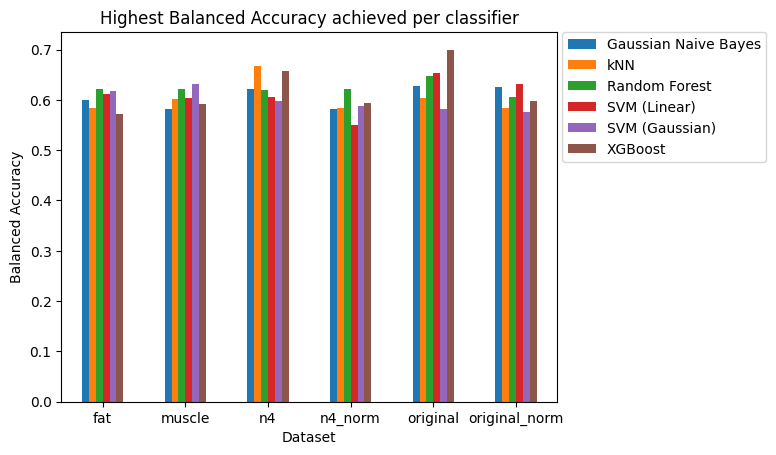

In [138]:
new_merged = merged.groupby(['fullDatasetName','classifierName'])['balanced_accuracy_score'].max().unstack().plot.bar(rot=0)

plt.xlabel('Dataset')
plt.ylabel('Balanced Accuracy')
plt.title('Highest Balanced Accuracy achieved per classifier')
plt.legend(['Gaussian Naive Bayes', 'kNN', 'Random Forest', 'SVM (Linear)', 'SVM (Gaussian)', 'XGBoost'], bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()

In [139]:
merged.groupby(['fullDatasetName','classifierName'])['balanced_accuracy_score'].max()

fullDatasetName  classifierName
fat              gnb               0.600000
                 knn               0.582866
                 rf                0.621651
                 svm-linear        0.611688
                 svm-rbf           0.616918
                 xgb               0.572673
muscle           gnb               0.581818
                 knn               0.601734
                 rf                0.621651
                 svm-linear        0.603285
                 svm-rbf           0.630927
                 xgb               0.592611
n4               gnb               0.621877
                 knn               0.667017
                 rf                0.620602
                 svm-linear        0.605276
                 svm-rbf           0.597222
                 xgb               0.658338
n4_norm          gnb               0.581818
                 knn               0.583502
                 rf                0.621651
                 svm-linear        0.550649


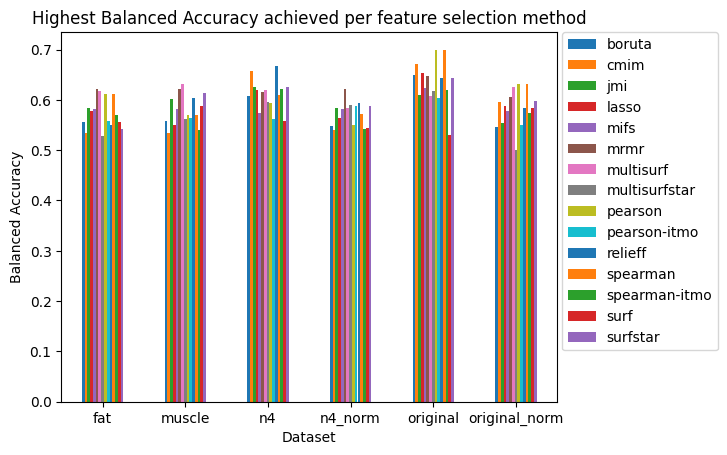

In [140]:
new_merged = merged.groupby(['fullDatasetName','featureSelectionMethodName'])['balanced_accuracy_score'].max().unstack().plot.bar(rot=0)

plt.xlabel('Dataset')
plt.ylabel('Balanced Accuracy')
plt.title('Highest Balanced Accuracy achieved per feature selection method')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()

#### Get resultrs per classifier

In [141]:
def convertClassifierName(name):
    if 'svm' in name:
        splt = name.split('-')
        ret = f'{splt[0].upper()} ({splt[1].title()} kernel)'
    elif name == 'gnb':
        ret = 'Gausian Naive Bayes'
    elif name == 'rf':
        ret = 'Random Forest'
    elif name == 'knn':
        ret = 'k-Nearest Neighbors'
    elif name == 'xgb':
        ret = 'XGBoost'
    else:
        return name.title()

    return ret

def convertFsMethodName(name):
    if name == 'boruta':
        return 'Boruta'
    elif 'spearman' in name or 'pearson' in name:
        return f"{name.title()} coefficient-based\nfeature selection"
    elif 'star' in name:
        return name.replace('star', '*').title() 
    elif 'urf' in name:
        return name.title()
    elif 'relieff' == name:
        return 'ReliefF'
    elif 'mrmr' == name:
        return 'mRMR'
    
    return name.upper()

def plotScoreByClassifier(classifierName):
    classfier = merged.loc[merged['classifierName'] == classifierName]
    classfier['fullDatasetName'] = classfier['fullDatasetName'].apply(lambda x: x.replace('_', ' ').title().replace('Norm', '\n(Normalized)'))
    classfier['featureSelectionMethodName'] = classfier['featureSelectionMethodName'].apply(lambda x: convertFsMethodName(x))
    classifierRes = classfier.groupby(['fullDatasetName','featureSelectionMethodName'])['balanced_accuracy_score'].max().unstack()

    ax = classifierRes.plot.bar(figsize=(8, 5), rot=0)
    plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left', borderaxespad=0)
    plt.title(convertClassifierName(classifierName))
    plt.xlabel('Dataset')
    plt.ylabel('Balanced Accuracy')
    ax.set(axisbelow=True)
    plt.grid(axis='y')
    
    path = Path(f'./data/results/plots/per_classifier/')
    path.mkdir(exist_ok=True)        
    plt.savefig(path.joinpath(f'{classifierName}_per_plot.jpeg'), bbox_inches='tight', dpi=300)

def plotScoreByFSMethod(featureSelectionMethodName):
    fsMethod = merged.loc[merged['featureSelectionMethodName'] == featureSelectionMethodName]
    fsMethod['fullDatasetName'] = fsMethod['fullDatasetName'].apply(lambda x: x.replace('_', ' ').title().replace('Norm', '\n(Normalized)'))
    fsMethod['classifierName'] = fsMethod['classifierName'].apply(lambda x: convertClassifierName(x))
    fsMethodRes = fsMethod.groupby(['fullDatasetName','classifierName'])['balanced_accuracy_score'].max().unstack()

    ax = fsMethodRes.plot.bar(figsize=(8, 5), rot=0)
    plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left', borderaxespad=0)
    plt.title(convertFsMethodName(featureSelectionMethodName))
    plt.xlabel('Dataset')
    plt.ylabel('Balanced Accuracy')
    ax.set(axisbelow=True)
    plt.grid(axis='y')
    
    path = Path(f'./data/results/plots/per_fs-method/')
    path.mkdir(exist_ok=True)        
    plt.savefig(path.joinpath(f'{featureSelectionMethodName}_per_plot.jpeg'), bbox_inches='tight', dpi=300)
    
classifiers = merged['classifierName'].unique().tolist()
methods = merged['featureSelectionMethodName'].unique().tolist()

C:\Users\szafeiris\AppData\Local\Temp\ipykernel_34404\438924705.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classfier['fullDatasetName'] = classfier['fullDatasetName'].apply(lambda x: x.replace('_', ' ').title().replace('Norm', '\n(Normalized)'))
C:\Users\szafeiris\AppData\Local\Temp\ipykernel_34404\438924705.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classfier['featureSelectionMethodName'] = classfier['featureSelectionMethodName'].apply(lambda x: convertFsMethodName(x))
C:\Users\szafeiri

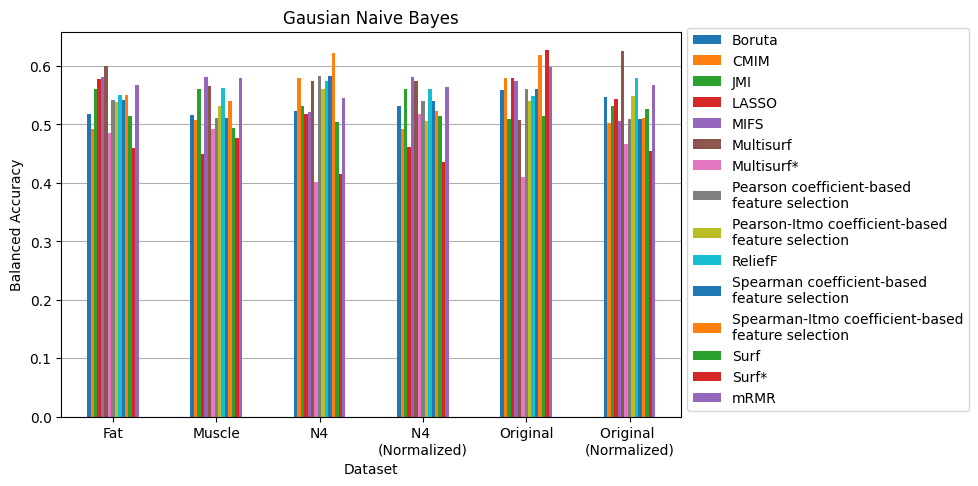

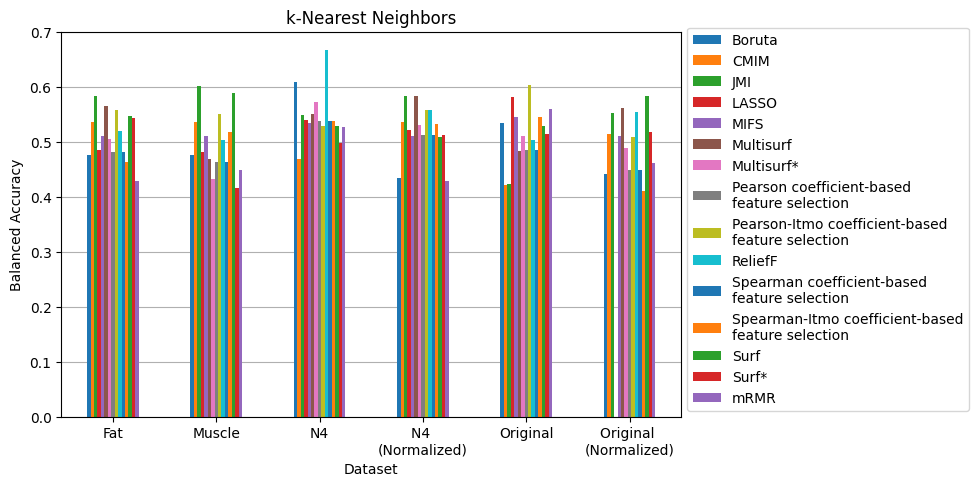

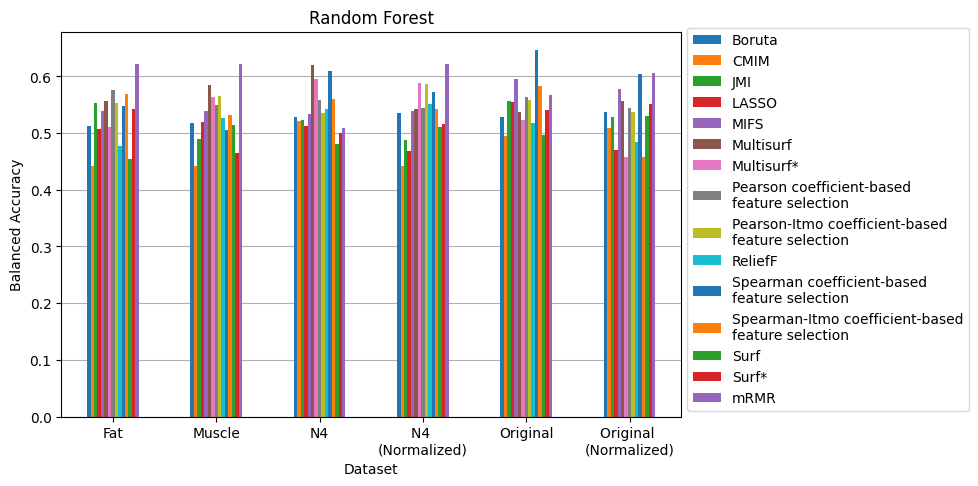

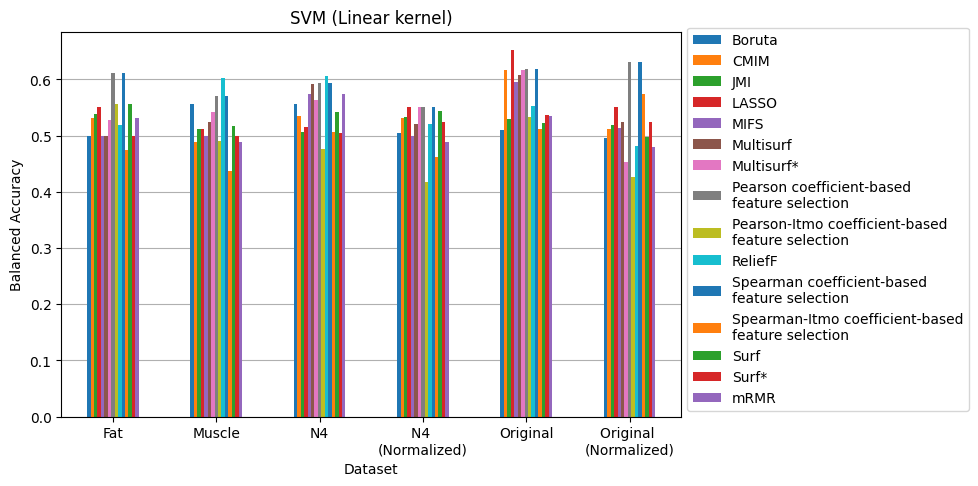

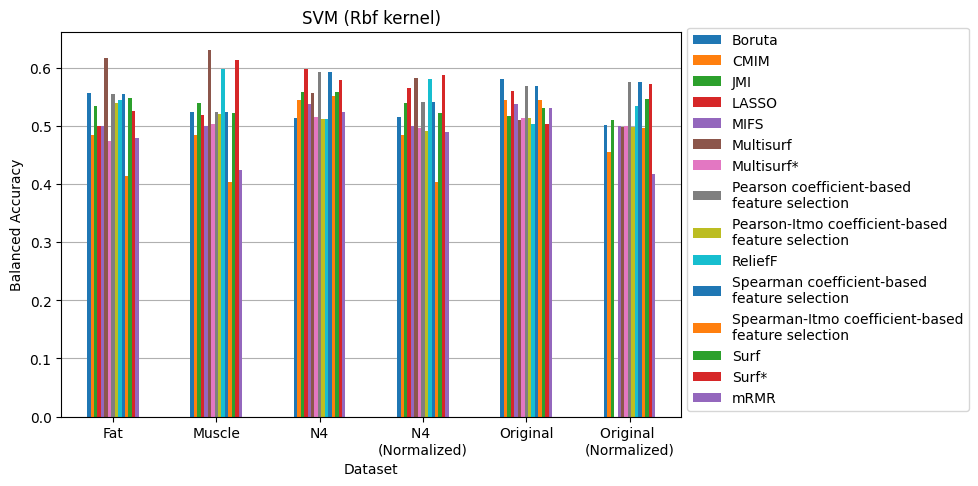

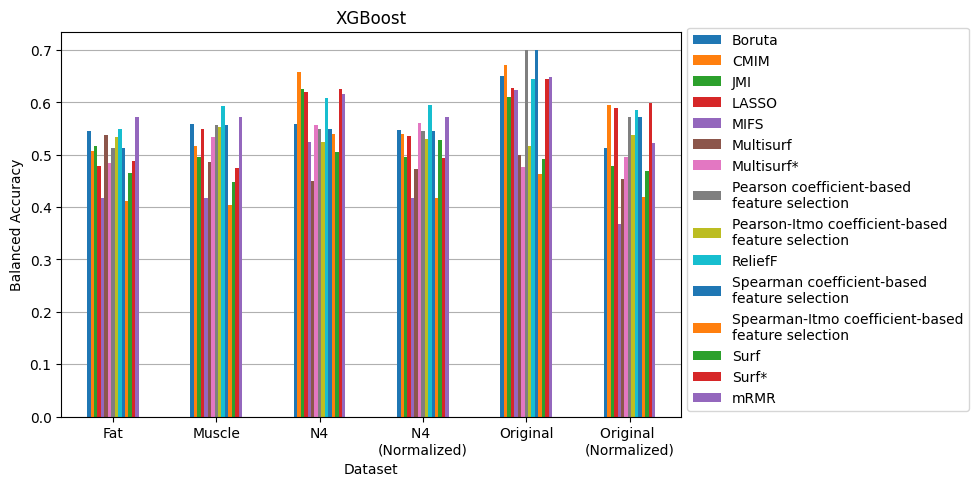

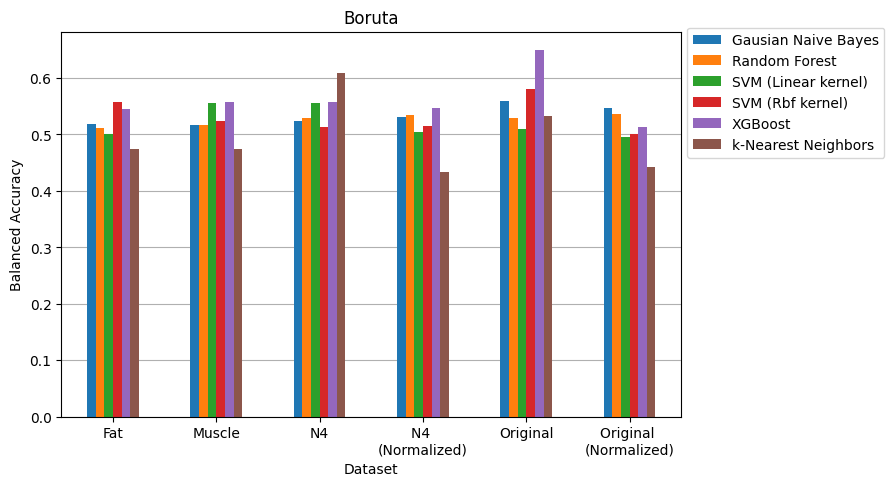

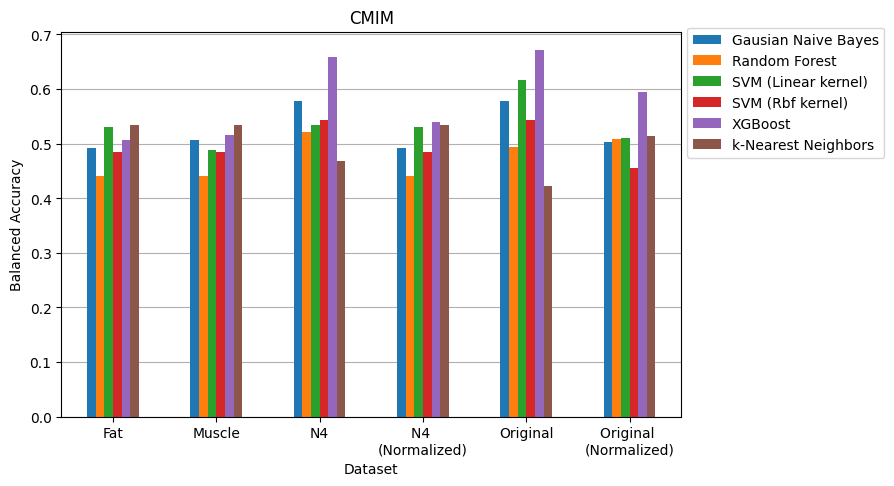

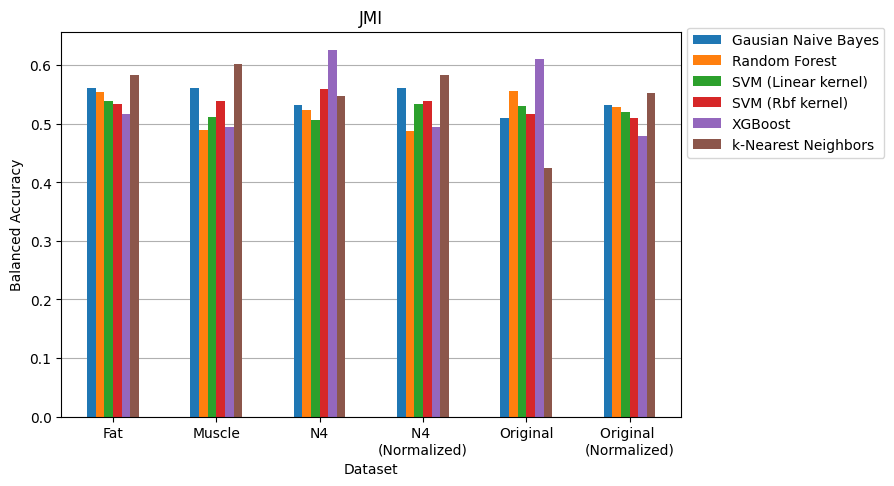

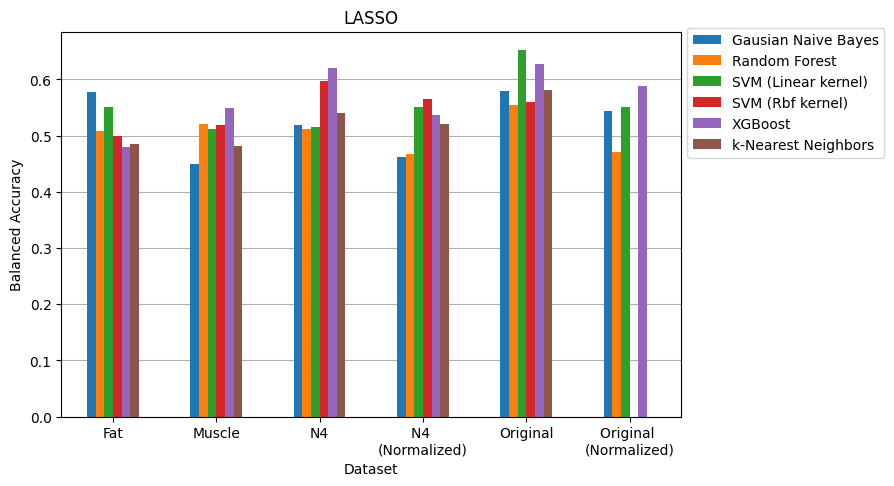

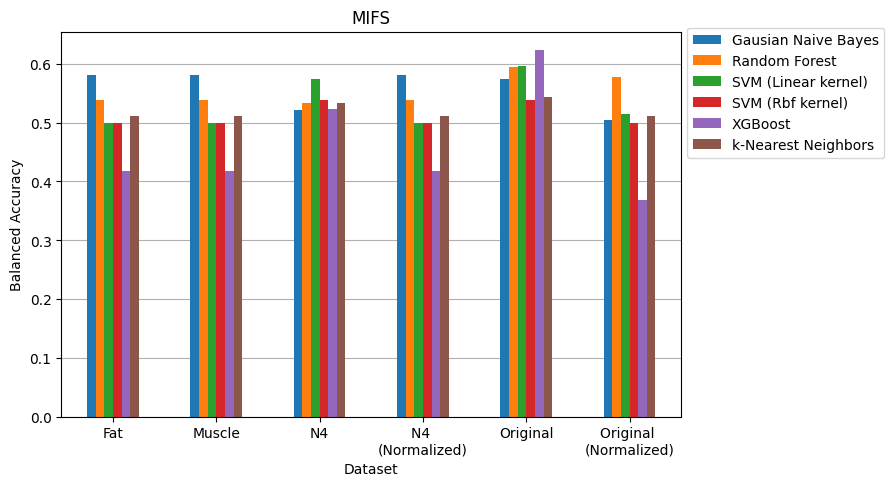

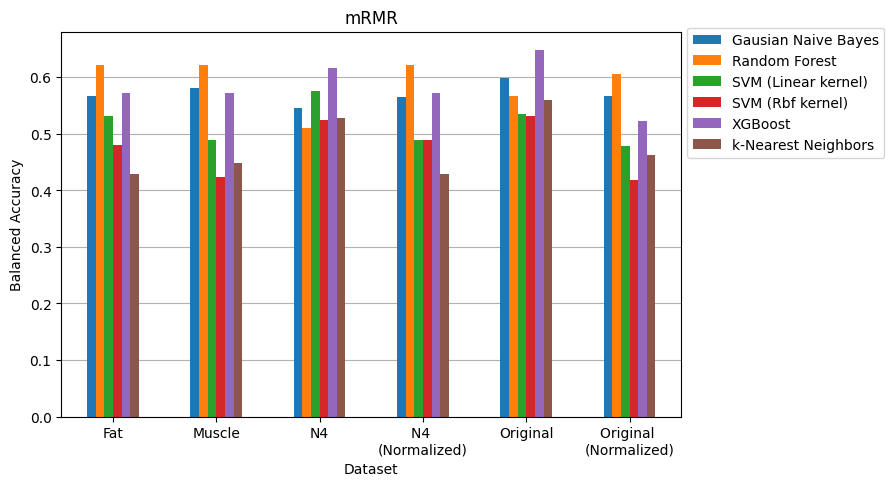

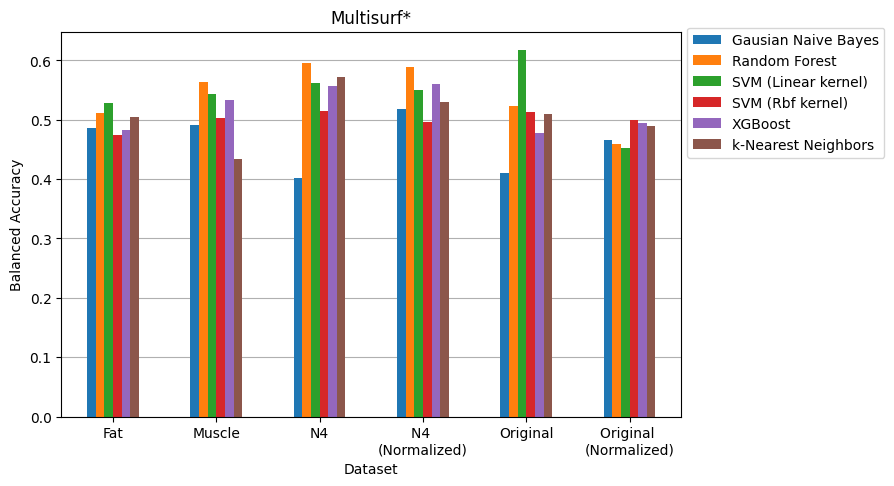

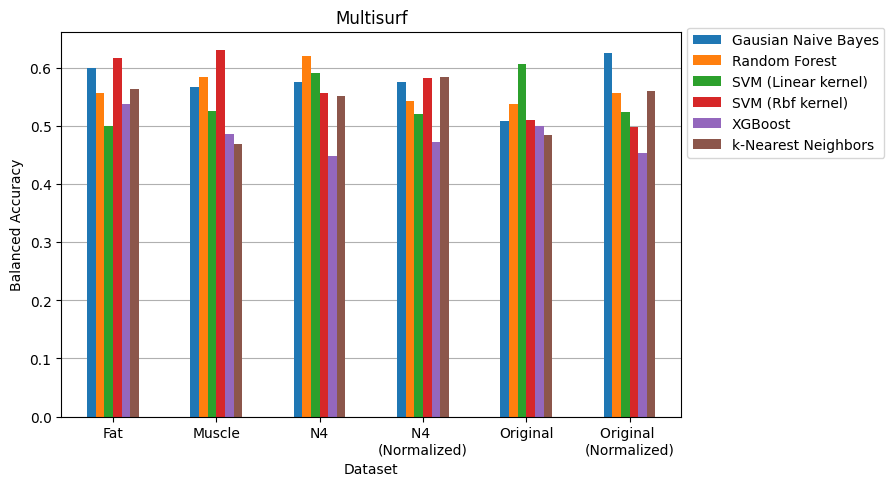

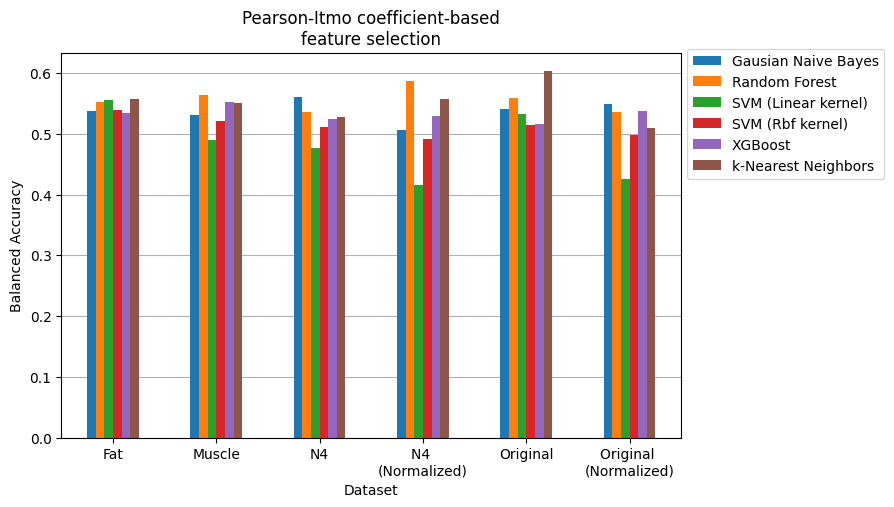

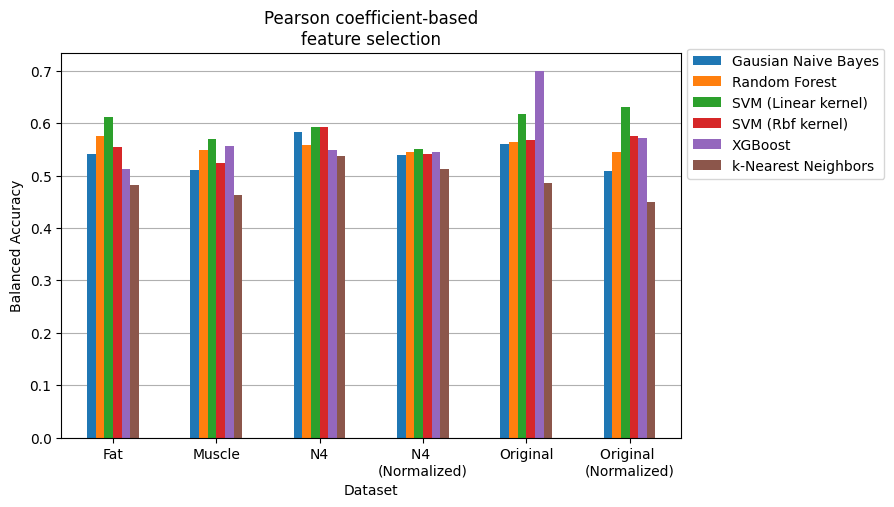

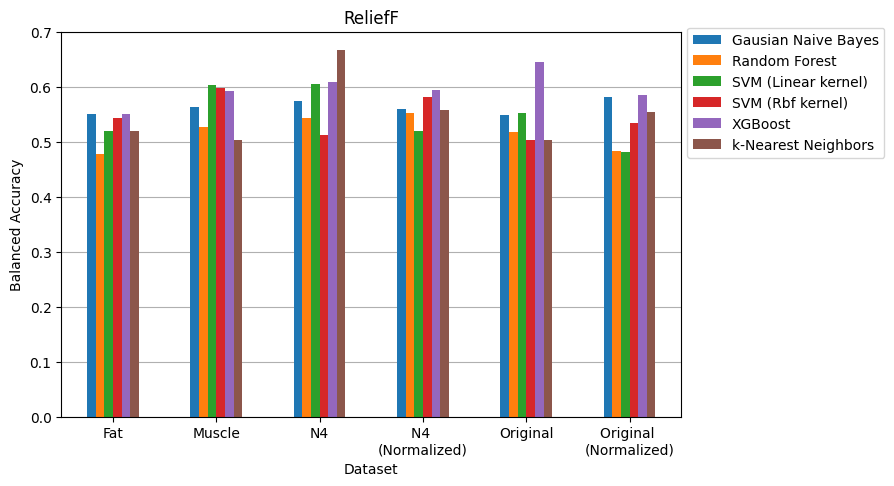

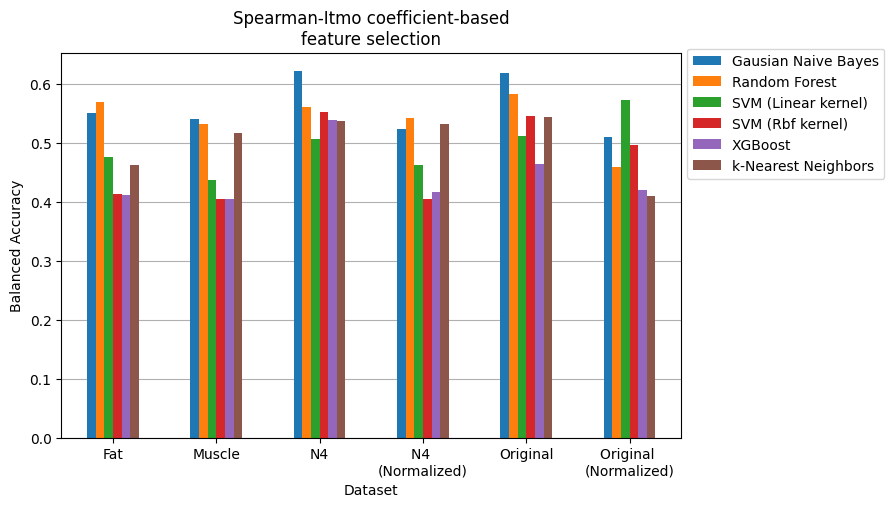

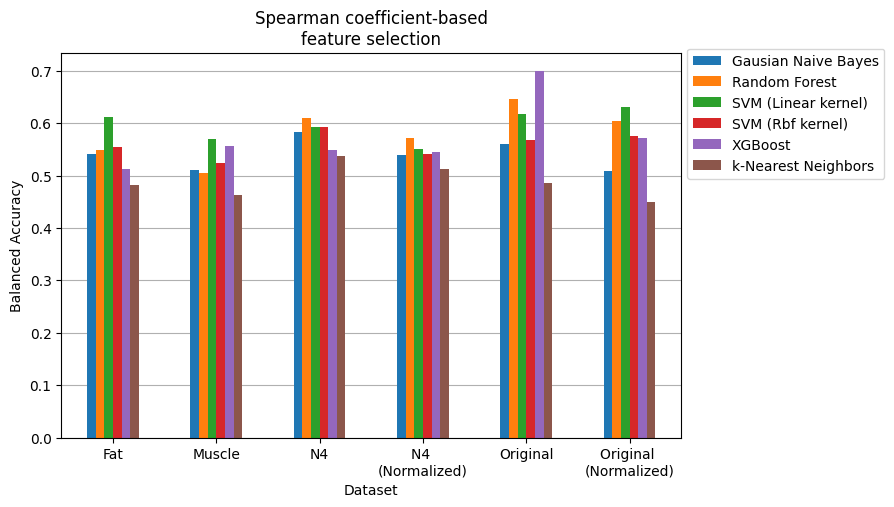

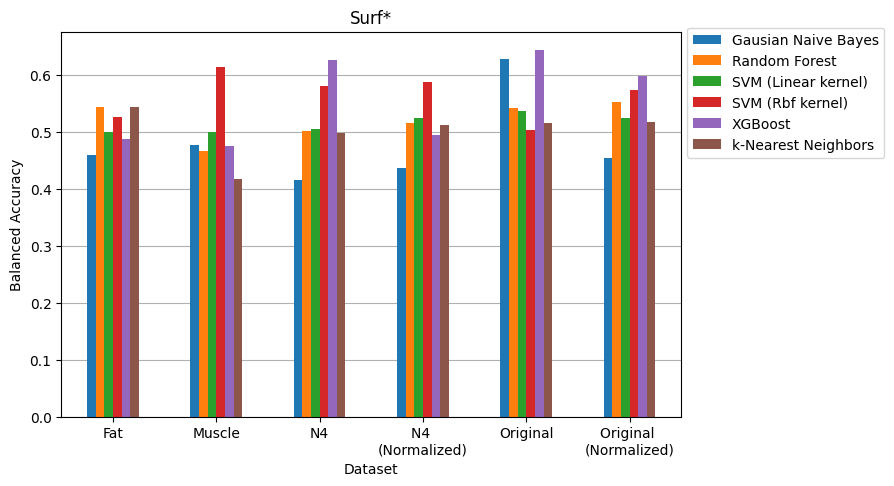

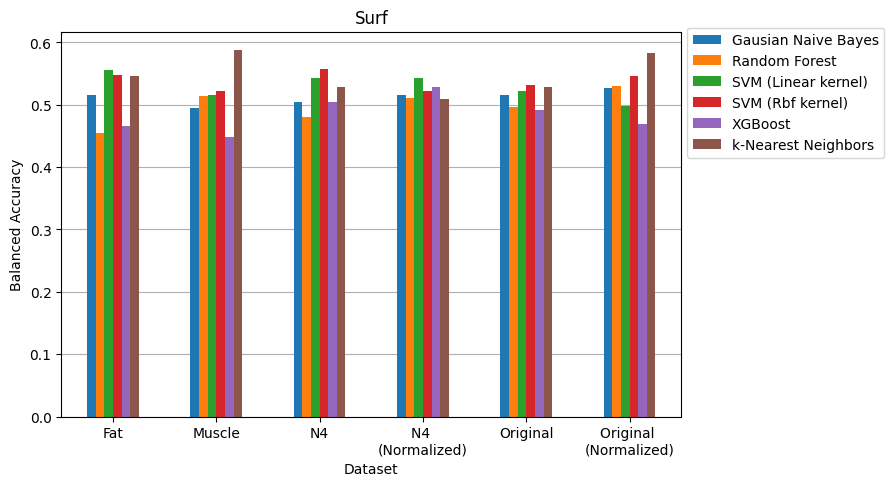

In [142]:
for c in classifiers:
    plotScoreByClassifier(c)

for m in methods:
    plotScoreByFSMethod(m)

In [143]:
topRows = merged.loc[merged['balanced_accuracy_score'] >= 0.60].copy()

# topRows['fullDatasetName'].unique().tolist()
topRows


,featureSelectionMethodName,classifierName,datasetName,isNormalized,selectedFeaturesNo,selectedThreshold,accuracy_score,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,cohen_kappa_score,TN,FP,FN,TP,fullDatasetName,sensitivity,speficity
5,boruta,xgb,original,False,96,0.00,0.677778,0.649920,0.553846,0.562500,0.545455,0.649920,0.301766,43,14,15,18,original,0.545455,0.754386
9,cmim,svm-linear,original,False,8,0.00,0.644444,0.617225,0.515152,0.515152,0.515152,0.617225,0.234450,41,16,16,17,original,0.515152,0.719298
11,cmim,xgb,original,False,73,0.00,0.700000,0.671851,0.584615,0.678571,0.513514,0.671851,0.356803,44,9,18,19,original,0.513514,0.830189
17,jmi,xgb,original,False,18,0.00,0.655556,0.609638,0.456140,0.650000,0.351351,0.609638,0.235616,46,7,24,13,original,0.351351,0.867925
21,lasso,svm-linear,original,False,55,0.00,0.677778,0.652500,0.539683,0.739130,0.425000,0.652500,0.318538,44,6,23,17,original,0.425000,0.880000
23,lasso,xgb,original,False,30,0.00,0.677778,0.627273,0.491228,0.636364,0.400000,0.627273,0.272981,47,8,21,14,original,0.400000,0.854545
29,mifs,xgb,original,False,63,0.00,0.655556,0.623988,0.507937,0.640000,0.421053,0.623988,0.259947,43,9,22,16,original,0.421053,0.826923
35,mrmr,xgb,original,False,68,0.00,0.666667,0.648084,0.545455,0.720000,0.439024,0.648084,0.305913,42,7,23,18,original,0.439024,0.857143
39,multisurfstar,svm-linear,original,False,93,0.00,0.644444,0.617500,0.483871,0.681818,0.375000,0.617500,0.246073,43,7,25,15,original,0.375000,0.860000
45,multisurf,svm-linear,original,False,58,0.00,0.633333,0.607089,0.492308,0.615385,0.410256,0.607089,0.222920,41,10,23,16,original,0.410256,0.803922


In [144]:
## Get unique for each column

print(topRows['featureSelectionMethodName'].unique().tolist())
print(topRows['classifierName'].unique().tolist())


['boruta', 'cmim', 'jmi', 'lasso', 'mifs', 'mrmr', 'multisurfstar', 'multisurf', 'pearson-itmo', 'pearson', 'relieff', 'spearman-itmo', 'spearman', 'surfstar']
['xgb', 'svm-linear', 'knn', 'gnb', 'rf', 'svm-rbf']


In [145]:
idxs = topRows.groupby('fullDatasetName')['balanced_accuracy_score'].transform(max) == topRows['balanced_accuracy_score']
df = topRows[idxs].reset_index()

df = df[['fullDatasetName', 'featureSelectionMethodName', 'classifierName', 'balanced_accuracy_score', 'selectedFeaturesNo', 'selectedThreshold']]
df

# from pandas.plotting import table
# ax = plt.subplot(111, frame_on=False) # no visible frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis

# table(ax, df, rowLabels=None)  # where df is your data frame
# plt.savefig('test.png', bbox_inches='tight')


,fullDatasetName,featureSelectionMethodName,classifierName,balanced_accuracy_score,selectedFeaturesNo,selectedThreshold
0,original,pearson,xgb,0.700000,175,0.85
1,original,spearman,xgb,0.700000,175,0.85
2,original_norm,pearson,svm-linear,0.631169,143,0.70
3,original_norm,spearman,svm-linear,0.631169,143,0.70
4,n4,relieff,knn,0.667017,68,0.00
5,n4_norm,mrmr,rf,0.621651,23,0.00
6,fat,mrmr,rf,0.621651,23,0.00
7,muscle,multisurf,svm-rbf,0.630927,18,0.00


In [186]:
p = muscleDataset.sort_values(by='balanced_accuracy_score', ascending=False)
p.loc[(p['featureSelectionMethodName'] == 'spearman') | (p['featureSelectionMethodName'] == 'pearson') ]


,featureSelectionMethodName,classifierName,datasetName,isNormalized,selectedFeaturesNo,selectedThreshold,accuracy_score,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,cohen_kappa_score,TN,FP,FN,TP
57,pearson,svm-linear,muscle,False,178,0.75,0.588889,0.570130,0.478873,0.472222,0.485714,0.570130,0.139535,36,19,18,17
75,spearman,svm-linear,muscle,False,178,0.75,0.588889,0.570130,0.478873,0.472222,0.485714,0.570130,0.139535,36,19,18,17
77,spearman,xgb,muscle,False,260,0.85,0.577778,0.555844,0.457143,0.457143,0.457143,0.555844,0.111688,36,19,19,16
59,pearson,xgb,muscle,False,260,0.85,0.577778,0.555844,0.457143,0.457143,0.457143,0.555844,0.111688,36,19,19,16
56,pearson,rf,muscle,False,512,0.95,0.588889,0.549351,0.412698,0.464286,0.371429,0.549351,0.102426,40,15,22,13
58,pearson,svm-rbf,muscle,False,260,0.85,0.588889,0.523377,0.301887,0.444444,0.228571,0.523377,0.051282,45,10,27,8
76,spearman,svm-rbf,muscle,False,260,0.85,0.588889,0.523377,0.301887,0.444444,0.228571,0.523377,0.051282,45,10,27,8
72,spearman,gnb,muscle,False,512,0.95,0.566667,0.510390,0.315789,0.409091,0.257143,0.510390,0.022284,42,13,26,9
54,pearson,gnb,muscle,False,512,0.95,0.566667,0.510390,0.315789,0.409091,0.257143,0.510390,0.022284,42,13,26,9
74,spearman,rf,muscle,False,145,0.70,0.566667,0.505195,0.290909,0.400000,0.228571,0.505195,0.011268,43,12,27,8
